In [1]:
# basic
import os
import pathlib
import random
import shutil
from typing import Dict, List, Tuple
# viz
import matplotlib.pyplot as plt
from PIL import Image
# torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
# torchvision
import torchvision
from torchvision import transforms, datasets
# torchmetrics
from torchmetrics import ConfusionMatrix
# from torchmetrics.classification import MulticlassAccuracy
from mlxtend.plotting import plot_confusion_matrix
# misc
from tqdm.auto import tqdm
# custom
from src import utils, engine, data_setup

c:\Users\arasyidi\AppData\Local\mambaforge\envs\torch_gpu\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1'

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preparation

1. Make training, validation and testing folder
1. Move 70% of the data to training folder
1. Move 20% of the data to validation folder
1. Move 10% of the data to testing folder

Folder structure after this process

```
data
    └─── EuroSAT_MS
        ├─── train
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_1.jpg
        |   |   ├─── AnnualCrop_2.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_1.jpg
        |   |   ├─── Forest_2.jpg
        |   |   └─── ...
        ├─── valid
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_3.jpg
        |   |   ├─── AnnualCrop_4.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_3.jpg
        |   |   ├─── Forest_4.jpg
        |   |   └─── ...
        └─── test
            └─── AnnualCrop
            |   ├─── AnnualCrop_1.jpg
            |   ├─── AnnualCrop_2.jpg
            |   └─── ...
            └─── Forest
                ├─── Forest_1.jpg
                ├─── Forest_2.jpg
                └─── ...
```

In [5]:
RANDOM_SEED = 42
BATCH_SIZE = 64

## Make a function to reorganize the folder

In [6]:
# Prepare the folder and its name
root_dir = os.getcwd()
root_dir = pathlib.Path(root_dir)

data_path = root_dir / "data"
original_eurosat_path = data_path / "EuroSAT"
new_eurosat_path = data_path / "EuroSAT_reorganized"

# Setup train, valid, and testing paths
train_path = new_eurosat_path / "train"
valid_path = new_eurosat_path / "valid"
test_path = new_eurosat_path / "test"

# put all the class names inside a list
class_name = os.listdir(original_eurosat_path)
print(class_name, len(class_name))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] 10


In [7]:
# Specify the source and destination folders
source_folder = original_eurosat_path
destination_folder = new_eurosat_path

# Specify the train, valid, and test ratios
train_ratio = 0.6
valid_ratio = 0.2

# Reorganize the folder structure
try:
    utils.reorganize_folder_structure(
        source_folder, 
        destination_folder, 
        train_ratio, 
        valid_ratio
        )
except:
    print("Folders already exist")

Folders already exist


## Check the result

River


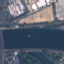

In [8]:
temp_class = random.choice(class_name)
index = random.randint(0,600)
print(temp_class)
Image.open(train_path / temp_class / os.listdir(train_path / temp_class)[index])

# Turn the data into a DataLoader

In [9]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT = train_dataset[0][0].shape[0], train_dataset[0][0].shape[1], train_dataset[0][0].shape[2]
print(IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT)

3 64 64


(-0.5, 63.5, 63.5, -0.5)

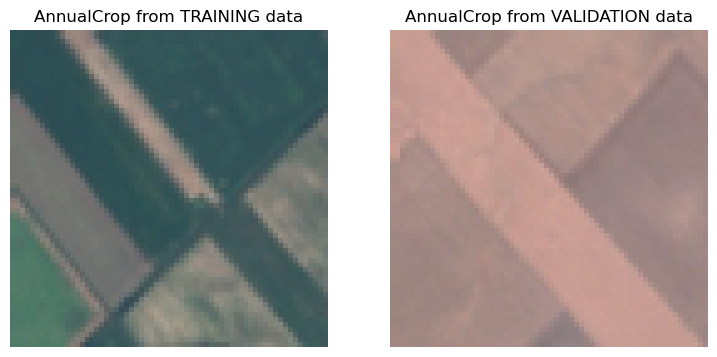

In [11]:
# check the data from train and valid dataset
fig = plt.figure(figsize=(9, 9))

img, label = train_dataset[index]
fig.add_subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from TRAINING data")
plt.axis(False)

img, label = valid_dataset[index]
fig.add_subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from VALIDATION data")
plt.axis(False)

# Training

## EfficientNet_B0

In [12]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights_enb0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_enb0 = torchvision.models.efficientnet_b0(weights=weights_enb0).to(device)

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_enb0,
        input_size=(BATCH_SIZE, IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 64, 64]      [64, 1000]           --                   True
├─Sequential (features)                                      [64, 3, 64, 64]      [64, 1280, 2, 2]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 64, 64]      [64, 32, 32, 32]     --                   True
│    │    └─Conv2d (0)                                       [64, 3, 64, 64]      [64, 32, 32, 32]     864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 32, 32]     [64, 32, 32, 32]     64                   True
│    │    └─SiLU (2)                                         [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
│    └─Sequential (1)                                        [64, 32, 32, 32]     [64, 16, 32,

### Model Modification

In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_enb0.features.parameters():
    param.requires_grad = False

In [15]:
# Set the manual seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_name)

# Recreate the classifier layer and seed it to the target device
model_enb0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Training Process

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_enb0.parameters(), lr=0.001)

In [17]:
# Setup training and save the results
EPOCH = 5
# metric = MulticlassAccuracy(num_classes=len(class_name)).to(device)

results = engine.train(
    model=model_enb0,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCH,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9187 | train_acc: 0.7192 | test_loss: 0.6776 | test_acc: 0.7944
Epoch: 2 | train_loss: 0.6418 | train_acc: 0.7881 | test_loss: 0.7220 | test_acc: 0.8136
Epoch: 3 | train_loss: 0.6020 | train_acc: 0.8030 | test_loss: 0.5650 | test_acc: 0.8068
Epoch: 4 | train_loss: 0.5847 | train_acc: 0.8049 | test_loss: 0.5535 | test_acc: 0.8124
Epoch: 5 | train_loss: 0.5759 | train_acc: 0.8069 | test_loss: 0.5399 | test_acc: 0.8206


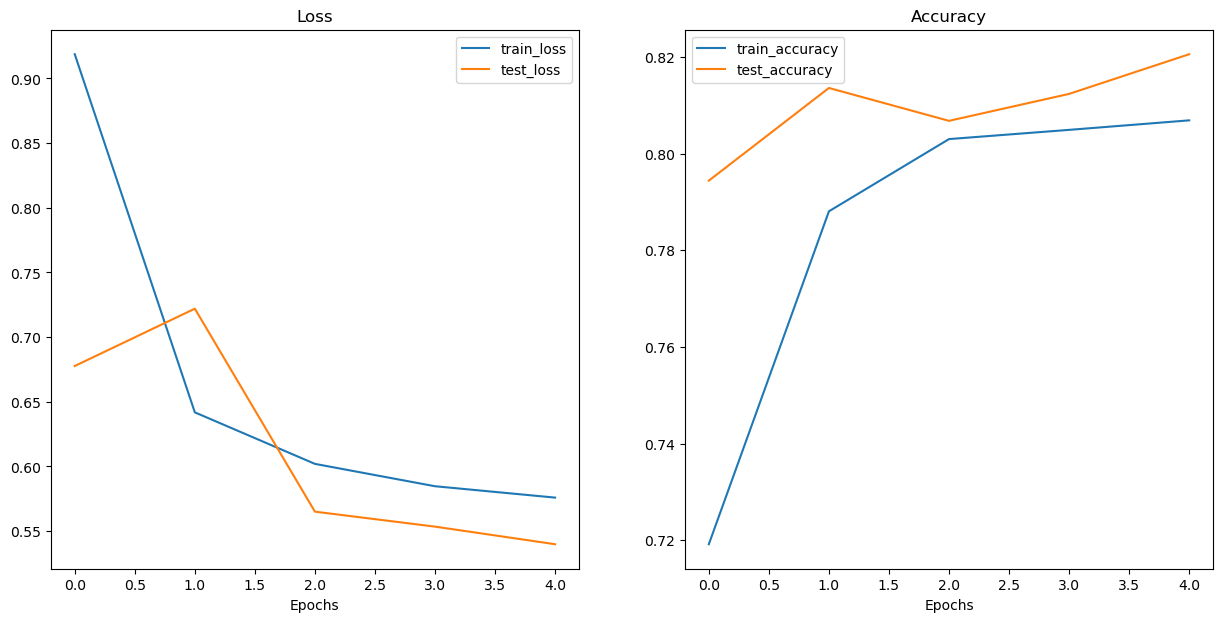

In [18]:
utils.plot_loss_curves(results)

### Make Prediction

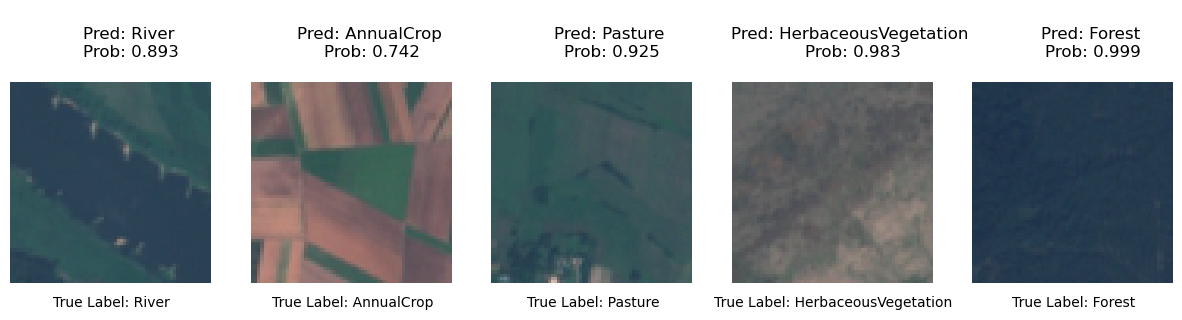

In [20]:
num_images_to_plot = 5
test_image_path_list = list(pathlib.Path(test_path).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
fig = plt.figure(figsize=(15,5))
for position, image_path in enumerate(test_image_path_sample):
    ax = fig.add_subplot(1, num_images_to_plot, position+1)
    utils.pred_and_plot_image(model=model_enb0, 
                        image_path=image_path,
                        class_names=class_name,
                        transform=transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(IMG_WIDTH, IMG_HEIGHT)
                        )
    ax.text(32,70, f"True Label: {image_path.parent.name}", ha='center', va='center')

In [21]:
# 1. Make predictions with trained model
y_preds = []
model_enb0.to(device).eval()
with torch.inference_mode():
  for X, y in tqdm(valid_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_enb0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

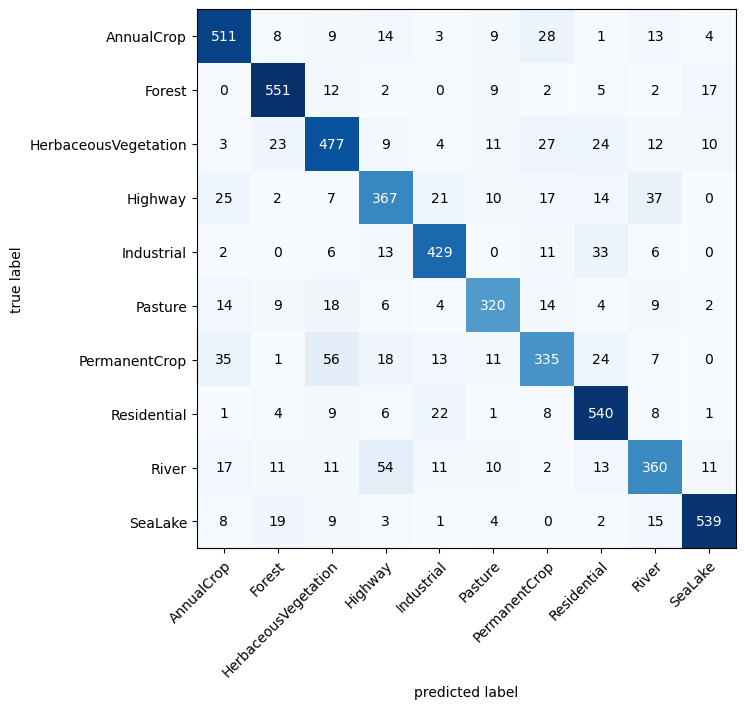

In [22]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(valid_dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_name, # turn the row and column labels into class names
    figsize=(10, 7)
);

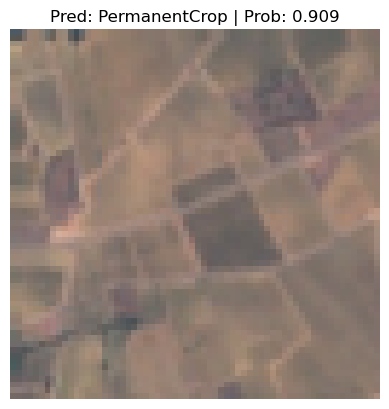

In [33]:
# get randomized index
temp_class = random.choice(class_name)
index = random.randint(0,600)

# open and transform the image
image_path = train_path / temp_class / os.listdir(train_path / temp_class)[index]
img = Image.open(image_path)
image_transform = transform
transformed_image = image_transform(img).unsqueeze(dim=0)

# make a prediction
target_image_pred = model_enb0(transformed_image.to(device))
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
target_image_pred_label

# plot the image
plt.figure()
plt.imshow(img)
plt.title(f"Pred: {class_name[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
plt.axis(False);

## UNET

# Experiment Tracking

## Tensorboard

## MLFlow